In [8]:
import os
import warnings
warnings.simplefilter('ignore')
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
import scipy as scp
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.labelsize'] = 16
import seaborn as sns
sns.set_palette('twilight')

from ptsa.data.timeseries import TimeSeries
from ptsa.data.concat import concat
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster 
# or SGECluster, etc. this is optional if you don't have a cluster available
# but this will be a challenge with such a large dataset
from nicls_helpers import *
from compute_scalp_features import compute_scalp_features
%load_ext autoreload
%autoreload 2

subject_list = np.loadtxt("final_subject_list.txt", dtype=str)
bids_root = "~/data/nicls_bids/"
intermediate_dir = "~/data/nicls_intermediate/"

In [9]:
# if running locally
client = Client()

# if running on HPC
# client = Client(
#     SLURMCluster(
#         job_name="NICLS",
#         memory="8GB",
#         cores=1,
#         processes=1,
#         walltime="01:00:00",
#         local_directory=os.expanduser("~/dask-worker-space/"),
#         log_directory=os.expanduser("~/logs/")
#     )
# )
# # adavptively scale workers based on demand
# client.cluster.adapt(minimum=0, maximum=100)

## Computing features

In [7]:
# settings that specify the eeg epoch loaded (start/stop relative to stimulus onset)
# as well as other parameters for neural data processing including the frequencies for computing 
# spectral power and the width of the morlet wavelets
ro_settings = pickle.load(open("settings/phase1_settings.pkl", "rb"))
print("READ ONLY SETTINGS\n", ro_settings)
cl_settings = pickle.load(open("settings/phase2_settings.pkl", "rb"))
print("CLOSED LOOP SETTINGS\n", cl_settings)

READ ONLY SETTINGS
 {'rel_start': 300, 'rel_stop': 1300, 'buffer_time': 500, 'freqs': array([  6.        ,   9.75368156,  15.85571732,  25.77526961,
        41.90062864,  68.11423148, 110.72742057, 180.        ]), 'width': 5, 'experiment': 'NiclsCourierReadOnly', 'clean': 0, 'save': 1, 'reference': 'average'}
CLOSED LOOP SETTINGS
 {'rel_start': 300, 'rel_stop': 1300, 'buffer_time': 500, 'freqs': array([  6.        ,   9.75368156,  15.85571732,  25.77526961,
        41.90062864,  68.11423148, 110.72742057, 180.        ]), 'width': 5, 'experiment': 'NiclsCourierClosedLoop', 'clean': 0, 'save': 1, 'reference': 'average'}


In [4]:
ro_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "settings/phase1_settings.pkl",
                        normalize = True, 
                        save_path = os.path.join(intermediate_dir, 'read_only/encoding_powers/')

In [36]:
cl_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "settings/phase2_settings.pkl",
                        normalize = True,
                        save_path = os.path.join(intermediate_dir, 'closed_loop/encoding_powers/'))

In [ ]:
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)
settings_path = "settings/phase2_settings.pkl"
save_path = os.path.join(intermediate_dir, "closed_loop/encoding_powers/")

futures = client.map(compute_scalp_features,
                        subject_list,
                        settings_path=settings_path,
                        normalize=False,
                        save_path=save_path)

## Decoding memory success

In [4]:
encoding_futures = client.map(
    load_and_fit_data_encoding, 
    [os.path.join(intermediate_dir, f"read_only/encoding_powers/{sub}_feats.h5") for sub in subject_list],
    group="session"
)

In [5]:
gathered_results_encoding = client.gather(encoding_futures)
full_results_encoding = pd.concat(gathered_results_encoding)

In [10]:
full_results_encoding.to_pickle("RO_classification_results_encoding.pkl")

In [11]:
## check that recall scales with classifier predicted probability
# from sklearn.calibration import calibration_curve

# full_results_encoding = pd.read_pickle("RO_classification_results_encoding.pkl")

predictions_recalls = pd.DataFrame()
for subject, subject_results in full_results_encoding.groupby("subject"):
    all_labels = np.array([])
    all_predictions = np.array([])
    for i, row in subject_results.iterrows():
        # all_labels = np.append(all_labels, row["y_true"])
        # all_predictions = np.append(all_predictions, row["y_pred"])
        # CalibrationDisplay.from_predictions(
        #     all_labels, 
        #     all_predictions, 
        #     strategy="uniform",
        #     ref_line=False
        # )
        subsess_predictions_recalls = pd.DataFrame(
            {"subject":subject,
             "session": row["holdout_session"],
             "recalled":row["y_true"], 
             "predicted":row["y_pred"]}
        )
        predictions_recalls = pd.concat([predictions_recalls, subsess_predictions_recalls], ignore_index=True)
predictions_recalls.to_csv("data/RO_encoding_loso_calibration_data.csv")

### Encoding ROC

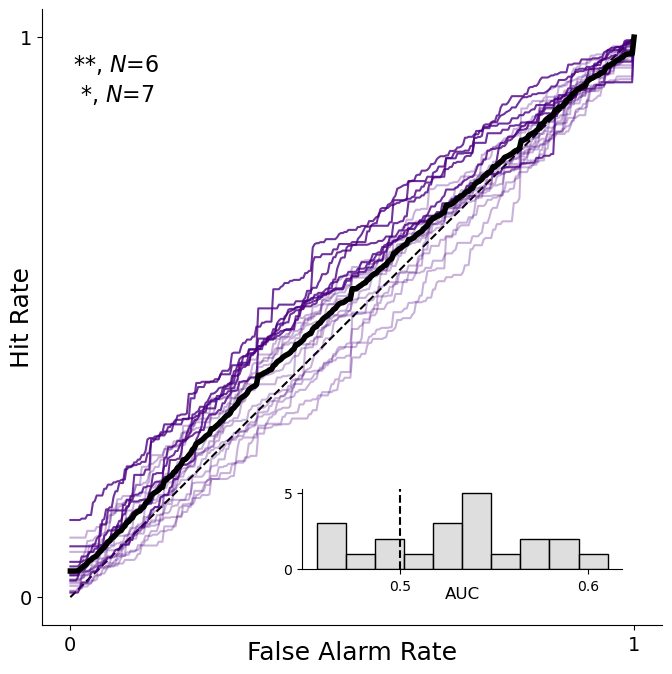

In [12]:
encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject, subject_results in full_results_encoding.groupby("subject"):
#     print(subject)
    subject_tp = []
    auc = []
    auc_null = []
    for i, row in subject_results.iterrows():
        if np.mean(row["y_true"]) in [0., 1.]:
            continue
        auc.append(row["AUC"])
        auc_null.append(row["null"])
        tp = np.interp(base_fp, row['fp'], row['tp'])
        subject_tp.append(tp)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    all_subjects_auc.append(auc)
    all_subjects_null_auc.append(np.mean(auc_null))
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    encoding_signif.update({subject:p})
    if p<=0.05:
        alpha=0.8
    else:
        alpha=0.3
    tp_list.append(np.mean(subject_tp, axis=0))
    ax.plot(base_fp, np.mean(subject_tp, axis=0), color='indigo', label=f"{subject}, AUC = {row['AUC']:.3f}", alpha=alpha)

top_ax = fig.add_axes([0.45, .18, .4, .1])
auc_dist = pd.DataFrame({"subject":np.unique(full_results_encoding["subject"]), "auc":all_subjects_auc})
auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
auc_dist['signif'] = auc_dist['p']<.05
top_ax.axvline(0.5, color='k', ls='--')
sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
top_ax.grid(False)
# top_ax.set_title('AUC', fontsize=14)
top_ax.set_xticks([.5, .6])
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.set_xlabel('AUC', fontsize=12, labelpad=-5)
top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=16)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=16)

plt.savefig('figures/nested_loso_encoding.pdf', dpi=200, bbox_inches='tight')

In [8]:
scp.stats.ttest_1samp(full_results_encoding.groupby("subject").agg({"AUC":"mean"}), 0.5)

Ttest_1sampResult(statistic=array([3.085581]), pvalue=array([0.0058324]))

In [9]:
mean = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).mean()[0]
sem = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).sem()[0]
print(f"mean AUC = {mean:.4f} +/- {sem:.4f} ")

mean AUC = 0.5292 +/- 0.0095 


### One-list normalization for closed loop

  0%|          | 0/21 [00:00<?, ?it/s]

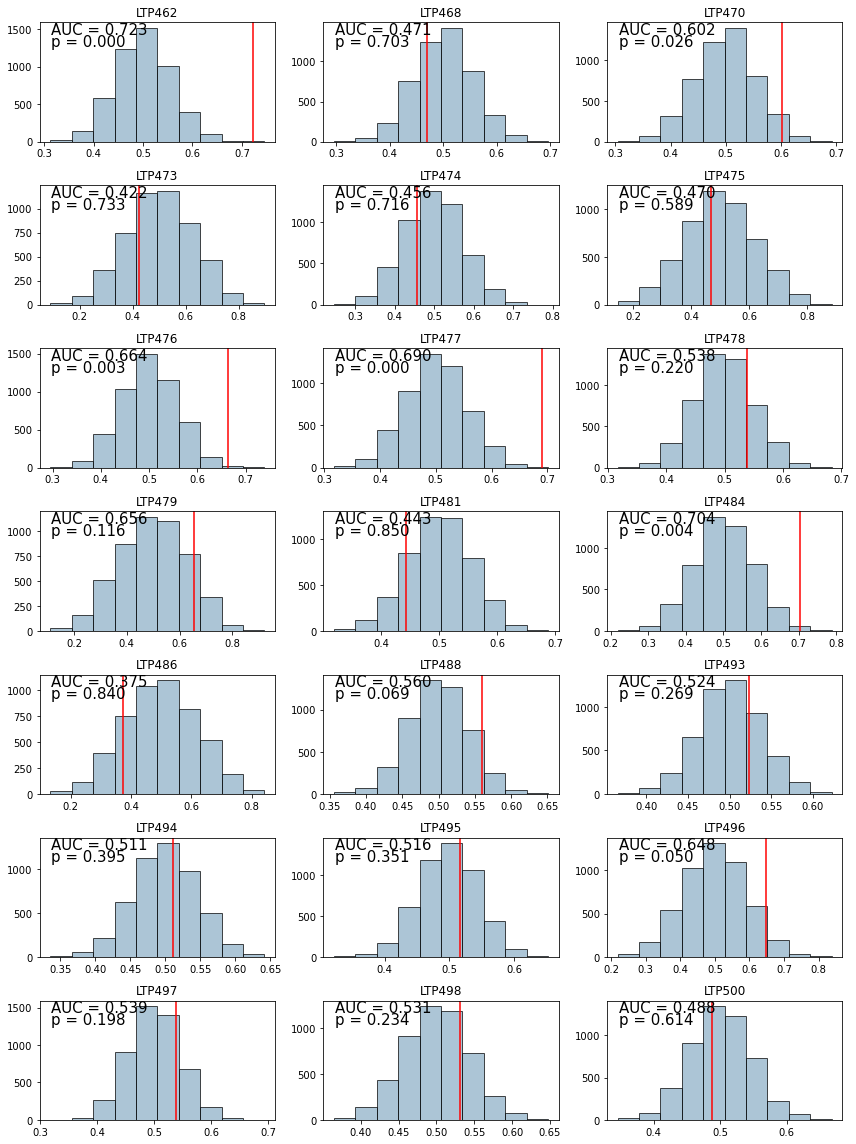

In [20]:
path = os.path.join(intermediate_dir, 'closed_loop/encoding_powers/')
base_fp = np.linspace(0, 1, 301)

# fig, ax = plt.subplots(len(subject_list) // 3 + len(subject_list) % 3, 3, figsize=(12, 16))
# ax = ax.ravel()
cl_result_dict = {}
session_level_results = {}
# behavioral events with classifier information integrated
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)

for i, subject in tqdm(list(enumerate(subject_list))):
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    # apply normalization based on features from just the first list
    ts = ts.groupby('session').apply(norm_sess_feats, n_lists=1)
    # load model that was used in the experiment (trained on full training set)
    model = ClassifierModel(
        LogisticRegression()
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    # only lists without classifier-based timing
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    sham_powers = ts.isel(event=evs.index)
    auc = []
    auc_null = []
    subject_tp = []
    session_level_results[subject] = {}
    for sess, sess_pows in sham_powers.groupby("session"): 
        prob = model.predict_proba(sess_pows.data)[:, 1]
        if np.mean(sess_pows.recalled.values) in [0., 1.]:
            continue
        fp, tp, _ = roc_curve(sess_pows.recalled.values, prob)
        tp = np.interp(base_fp, fp, tp)
        subject_tp.append(tp)
        score, null, p_val = post_hoc_permutation(y_true=sess_pows.recalled.values, y_score = prob)
        session_level_results[subject][sess] = (score, null, p_val)
        auc.append(score)
        auc_null.append(null)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    cl_result_dict[subject] = (fp, np.mean(subject_tp, axis=0), auc, auc_null)
    
    # ax[i].set_title(subject)
    # ax[i].hist(auc_null, ec='k', alpha=.7)
    # ax[i].axvline(auc, c='r')
    # ax[i].annotate(f'p = {p:.3f}', xy=(.05, .8), xycoords='axes fraction', fontsize=15)
    # ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=15)
# plt.tight_layout()

In [11]:
with open(f"CL_classification_results_encoding.pkl", "wb") as f:
    pickle.dump(cl_result_dict, f)
df_session_results = pd.DataFrame(session_level_results).melt(var_name="subject")
df_session_results[["score", "perm_scores", "pval"]] = df_session_results['value'].apply(pd.Series)
df_session_results = df_session_results.dropna().drop(columns=["value"])
df_session_results["session"] = df_session_results.groupby("subject").cumcount()
df_session_results.to_pickle("CL_session_classification_results.pkl")
df_session_results

In [19]:
df_session_results = pd.read_pickle("CL_session_classification_results.pkl")

In [20]:
scp.stats.ttest_1samp(df_session_results.groupby("subject").agg({"score":"mean"}), 0.5)

Ttest_1sampResult(statistic=array([2.26357484]), pvalue=array([0.03487622]))

In [21]:
mean = df_session_results.groupby("subject").agg({"score":"mean"}).mean()[0]
sem = df_session_results.groupby("subject").agg({"score":"mean"}).sem()[0]
print(f"mean AUC = {mean:.4f} +/- {sem:.4f} ")

mean AUC = 0.5491 +/- 0.0217 


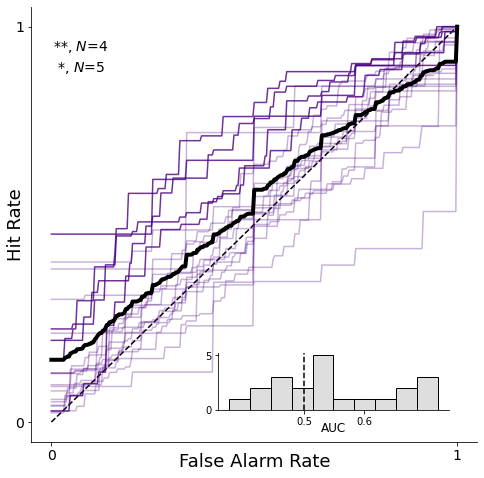

In [23]:
with open(f"CL_classification_results_encoding.pkl", "rb") as f:
    cl_result_dict = pickle.load(f)
encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject in cl_result_dict:
#     print(subject)
    (fp, tp, auc, auc_null) = cl_result_dict[subject]
    all_subjects_auc.append(auc)
    all_subjects_null_auc.append(np.mean(auc_null))
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    encoding_signif.update({subject:p})
    if p<=0.05:
        alpha=0.8
    else:
        alpha=0.3
    tp_list.append(tp)
    ax.plot(base_fp, tp, color='indigo', label=f"{subject}, AUC = {auc:.3f}", alpha=alpha)

top_ax = fig.add_axes([0.45, .18, .4, .1])
auc_dist = pd.DataFrame({"subject":np.array([s for s in cl_result_dict]), "auc":all_subjects_auc})
auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
auc_dist['signif'] = auc_dist['p']<.05
top_ax.axvline(0.5, color='k', ls='--')
sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
top_ax.grid(False)
# top_ax.set_title('AUC', fontsize=14)
top_ax.set_xticks([.5, .6])
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.set_xlabel('AUC', fontsize=12, labelpad=-5)
top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=14)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=14)

plt.savefig('CL_nested_loso_encoding.pdf', dpi=200, bbox_inches='tight')

In [7]:
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)
recall_by_cond = CL_evs.query("type=='WORD' and trial_type in ['Neg', 'Pos', 'Sham']").groupby(["subject", "session", "trial_type"]).agg({"recalled":np.nanmean, "probability":np.nanmean}).reset_index()
recall_by_cond

,subject,session,trial_type,recalled,probability
0,LTP462,0,Neg,0.333333,0.485012
1,LTP462,0,Pos,0.666667,0.504499
2,LTP462,0,Sham,0.300000,0.487880
3,LTP462,1,Neg,0.622222,0.485941
4,LTP462,1,Pos,0.488889,0.505100
...,...,...,...,...,...
199,LTP500,2,Pos,0.666667,0.938249
200,LTP500,2,Sham,0.600000,0.671470
201,LTP500,3,Neg,0.777778,0.174701
202,LTP500,3,Pos,0.688889,0.946089


In [81]:
performance_stats = pd.read_csv("data/system_performance_stats_FR_only.csv", header=[0, 1], index_col=[0, 1])
print(f"Losing {performance_stats['bad_session'].values.sum()} sessions with bad system performance")
recall_by_cond = pd.concat([recall_by_cond.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])
# matched_recall_by_cond = pd.concat([matched_recall_by_cond.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])

Losing 7 sessions with bad system performance


In [86]:
scores = []
pvals = []
for i, row in recall_by_cond.iterrows():
    try:
        scores.append(df_session_results.query(f"subject=='{row['subject']}' and session=={row['session']}")["score"].values[0])
        pvals.append(df_session_results.query(f"subject=='{row['subject']}' and session=={row['session']}")["pval"].values[0])
    except IndexError:
        scores.append(None)
        pvals.append(None)
recall_by_cond["score"] = np.array(scores)
recall_by_cond["pval"] = np.array(pvals)
recall_by_cond.dropna(subset=["score", "pval"], inplace=True)

# recall_by_cond.to_csv("data/memory_improvement_data.csv", index=False)

## Full-session Normalization

  0%|          | 0/21 [00:00<?, ?it/s]

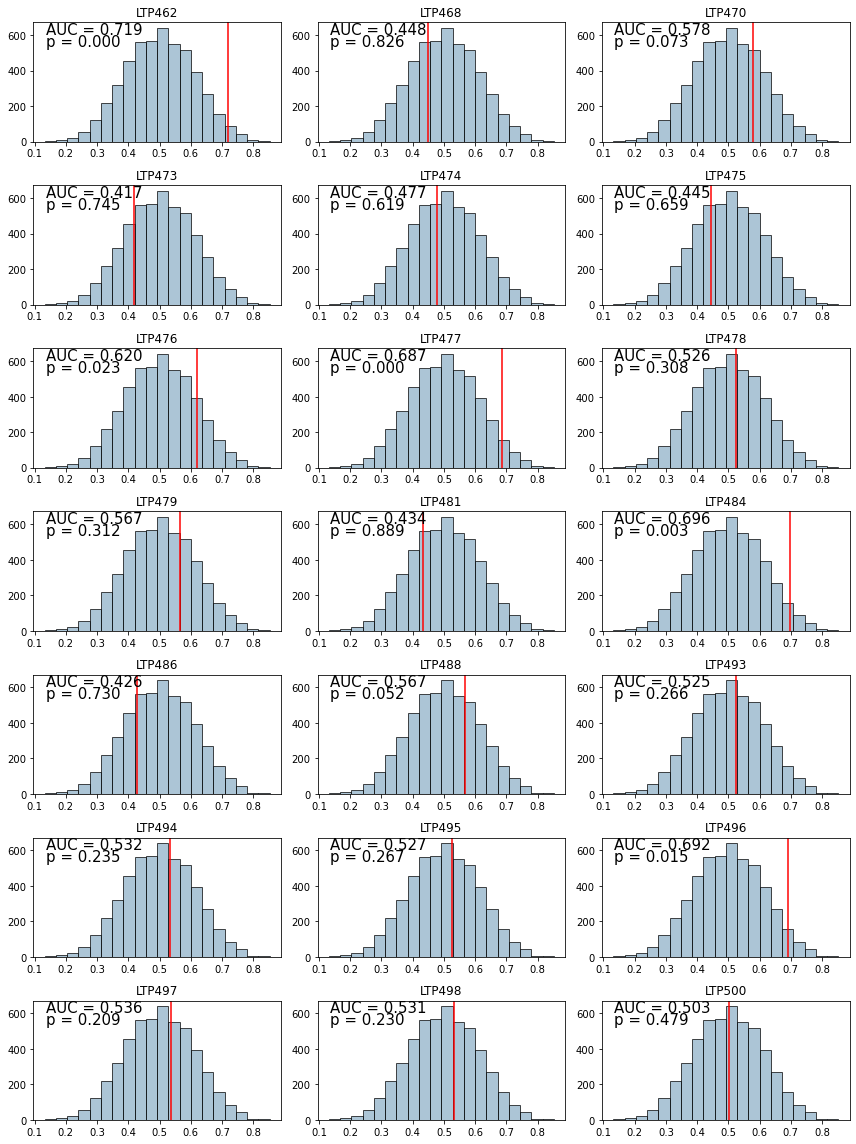

In [36]:
from scipy.stats import zscore
path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/'
base_fp = np.linspace(0, 1, 301)

fig, ax = plt.subplots(len(subject_list) // 3 + len(subject_list) % 3, 3, figsize=(12, 16))
ax = ax.ravel()
cl_result_dict = {}
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)

for i, subject in tqdm(list(enumerate(subject_list))):
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').reduce(func=zscore, dim='event', keep_attrs=True, ddof=1)
    
    model = ClassifierModel(
        LogisticRegression()
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    sham_powers = ts.isel(event=evs.index)
    auc = []
    auc_null = []
    subject_tp = []
    for sess, sess_pows in sham_powers.groupby("session"): 
        prob = model.predict_proba(sess_pows.data)[:, 1]
        if np.mean(sess_pows.recalled.values) in [0., 1.]:
            continue
        fp, tp, _ = roc_curve(sess_pows.recalled.values, prob)
        tp = np.interp(base_fp, fp, tp)
        subject_tp.append(tp)
        score, null, p_val = post_hoc_permutation(y_true=sess_pows.recalled.values, y_score = prob)
        auc.append(score)
        auc_null.append(null)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    p_val = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    cl_result_dict[subject] = (fp, np.mean(subject_tp, axis=0), auc, auc_null)
    
    ax[i].set_title(subject)
    ax[i].hist(auc_results, ec='k', alpha=.7, bins=20)
    ax[i].axvline(auc, c='r')
    ax[i].annotate(f'p = {p_val:.3f}', xy=(.05, .8), xycoords='axes fraction', fontsize=15)
    ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=15)
plt.tight_layout()

Text(0.5, 0, 'Predicted Probability')

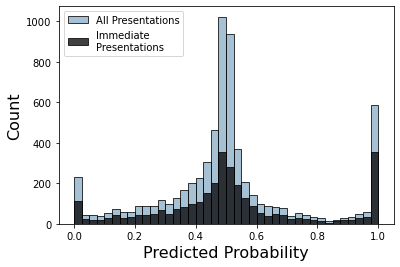

In [34]:
plt.rcParams['figure.facecolor']='white'
sns.histplot(data=CL_evs.query("type=='WORD' & trial_type!='NoStim'"), x="probability", bins=40, label='All Presentations')
sns.histplot(data=CL_evs.query("type=='WORD' & trial_type!='NoStim' & wait_time<=50"), x="probability", bins=40, color='k', label='Immediate\nPresentations')
plt.legend(loc=2)
plt.xlabel("Predicted Probability")

## Behavioral plots

In [14]:
performance_stats = pd.read_csv("data/system_performance_stats_FR_only.csv", header=[0, 1], index_col=[0, 1])
print(f"Losing {performance_stats['bad_session'].values.sum()} sessions with bad system performance")
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)
CL_evs = pd.concat([CL_evs.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])
df_session_results = pd.read_pickle("CL_session_classification_results.pkl")
scores = df_session_results.groupby("subject", as_index=False).agg({"score":"mean"}).rename(columns={"score":"AUC"})
CL_evs = pd.merge(CL_evs, scores, on="subject")
CL_evs.to_csv("data/processed_events_with_AUC.csv")
encoding_evs = CL_evs.query("type=='WORD' and trial_type!='NoStim'")

Losing 7 sessions with bad system performance


In [15]:
recall_by_trial_type = encoding_evs.groupby(["subject", "trial_type"], as_index=False).agg({"recalled":"mean", "AUC":"mean"})

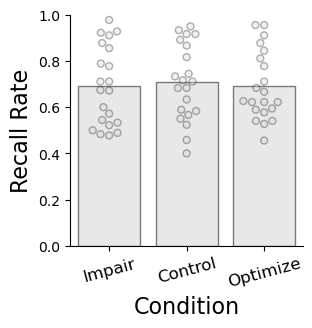

In [184]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
sns.barplot(
    data = recall_by_trial_type, 
    x="trial_type",
    y="recalled",
    color='lightgray',
    edgecolor='k',
    alpha=0.5,
    ax=ax,
    ci=None,
    capsize=.1, 
    errwidth=2, 
    errcolor='gray',
    order = ["Neg", "Sham", "Pos"]
)
sns.swarmplot(
    data = recall_by_trial_type, 
    x="trial_type",
    y="recalled",
    color="lightgray",
    edgecolor='k',
    linewidth=1,
    alpha=0.3,
    # kind="violin",
    # hue="subject"
    ax=ax,
    order = ["Neg", "Sham", "Pos"]
)

plt.xlabel("Condition")
plt.ylabel("Recall Rate")
plt.ylim(0,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(["Impair", "Control", "Optimize"], fontsize=12, rotation=15)

plt.savefig("figures/overall_recall_rates_by_condition.pdf", dpi=200, bbox_inches="tight")

In [16]:
trial_type_comparisons = pd.DataFrame({"subject":recall_by_trial_type["subject"].unique(), "AUC":recall_by_trial_type["AUC"].round(18).unique()})
trial_type_comparisons["Optimize vs. Impair"] = recall_by_trial_type.query("trial_type=='Pos'")["recalled"].values - recall_by_trial_type.query("trial_type=='Neg'")["recalled"].values
trial_type_comparisons["Optimize vs. Control"] = recall_by_trial_type.query("trial_type=='Pos'")["recalled"].values - recall_by_trial_type.query("trial_type=='Sham'")["recalled"].values
trial_type_comparisons["Impair vs. Control"] = recall_by_trial_type.query("trial_type=='Neg'")["recalled"].values - recall_by_trial_type.query("trial_type=='Sham'")["recalled"].values
pivoted_trial_comparisons = trial_type_comparisons.melt(id_vars=["subject", "AUC"],value_vars=["Optimize vs. Impair", "Optimize vs. Control", "Impair vs. Control"], value_name="delta_recall", var_name="comparison")

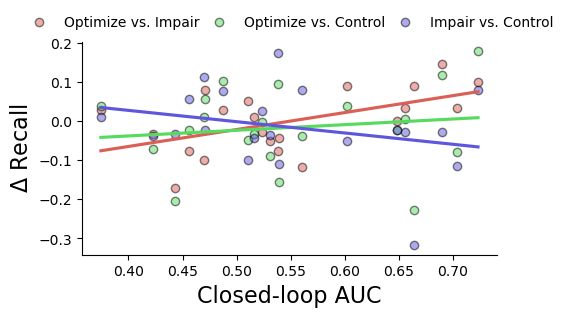

In [188]:
sns.set_palette('hls', 3)
# fig, ax = plt.subplots(1, 1)
facet = sns.lmplot(data=pivoted_trial_comparisons, 
                   scatter_kws = dict(alpha=0.5, edgecolor='k'),
                   x="AUC", y="delta_recall", hue="comparison",
                   legend=True, ci=None, height=3, aspect=1.8, legend_out=True)
ax= facet.axes[0][0]
ax.set_ylabel(r"$\Delta$ Recall")
ax.set_xlabel("Closed-loop AUC")
ax.legend(facet._legend_data.values(), facet._legend_data)
facet.legend.remove()
sns.move_legend(
    ax, "lower center", handles=facet._legend_data.values(), labels=facet._legend_data,
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, columnspacing=.4
)

plt.savefig("figures/AUC_recall_correlation.pdf", dpi=300, bbox_inches="tight")

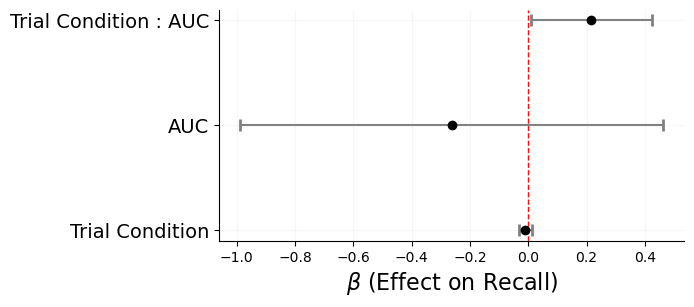

In [174]:
model_linear = pd.read_csv("results/linear_model.csv", index_col=0)[1:]
model_linear = model_linear[model_linear.effect=='fixed']
model_linear['conf.low'] = (model_linear['estimate'] - model_linear['conf.low']).abs()
model_linear['conf.high'] = (model_linear['conf.high'] - model_linear['estimate']).abs()
model_linear["term"] = model_linear["term"].str.strip("()")

plt.figure(figsize=(6,3))
ax = plt.gca()
ax.errorbar(model_linear['estimate'], range(len(model_linear)), xerr=model_linear['conf.low'],
            ls='', capsize=4, capthick=2, color='gray', zorder=1)
ax.scatter(model_linear['estimate'], range(len(model_linear)), color='k', zorder=2)
## proper axis labeling
ax.set_yticks(range(len(model_linear["term"].values)))
# ax.set_yticklabels(model_linear["term"].values)
ax.set_yticklabels(["Trial Condition", "AUC", "Trial Condition : AUC"], fontsize=14)
## zero-line
ax.axvline(ls='--', lw=1, color='r', zorder=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.grid(alpha=0.1)
ax.set_xlabel(r"$\beta$ (Effect on Recall)")
# plt.savefig("figures/coefplot_linear_model.pdf", dpi=300, bbox_inches="tight")

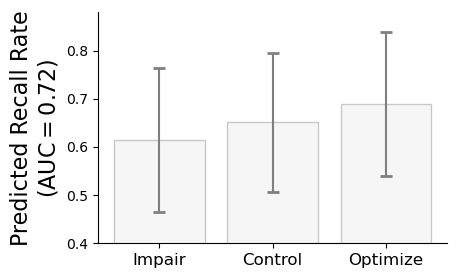

In [8]:
model_max_AUC_emmeans = pd.read_csv("results/max_auc_emmeans_linear.csv", index_col=0)
model_max_AUC_emmeans['conf.low'] = (model_max_AUC_emmeans['estimate'] - model_max_AUC_emmeans['conf.low']).abs()
model_max_AUC_emmeans['conf.high'] = (model_max_AUC_emmeans['conf.high'] - model_max_AUC_emmeans['estimate']).abs()

plt.figure(figsize=(4.5, 3))
ax = plt.gca()
ax.bar(x=range(3), height=model_max_AUC_emmeans['estimate'], yerr=model_max_AUC_emmeans['conf.low'],
       color='lightgray', alpha=.2, edgecolor='k', ecolor='gray', error_kw=dict(capsize=4, capthick=2, color='gray')) #color=["C0", "C1", "C2"]
ax.set_ylim(0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(["Impair", "Control", "Optimize"], fontsize=12)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylabel("Predicted Recall Rate\n" "(AUC$=0.72$)")
# plt.savefig("figures/max_AUC_predictions.pdf", dpi=300, bbox_inches="tight")

#### Joint Plot

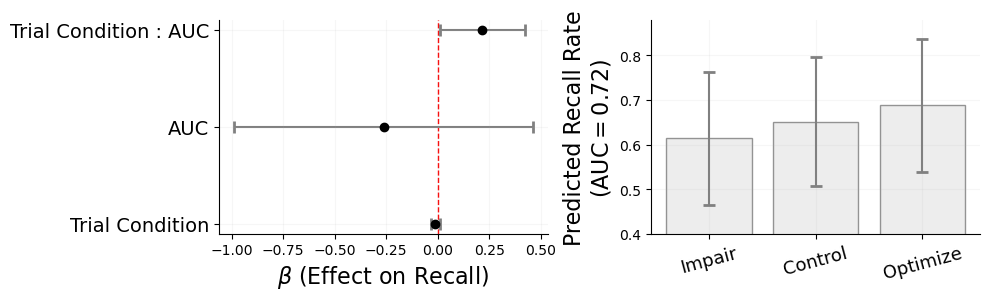

In [180]:
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(1, 4)
ax = fig.add_subplot(gs[:2])
ax.errorbar(model_linear['estimate'], range(len(model_linear)), xerr=model_linear['conf.low'],
            ls='', capsize=4, capthick=2, color='gray', zorder=1)
ax.scatter(model_linear['estimate'], range(len(model_linear)), color='k', zorder=2)
## proper axis labeling
ax.set_yticks(range(len(model_linear["term"].values)))
# ax.set_yticklabels(model_neg_intercept["term"].values)
ax.set_yticklabels(["Trial Condition", 
                    "AUC", "Trial Condition : AUC"], fontsize=14)
## zero-line
ax.axvline(ls='--', lw=1, color='r', zorder=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.grid(alpha=0.1)
ax.set_xlabel(r"$\beta$ (Effect on Recall)")

ax = fig.add_subplot(gs[2:])
ax.bar(x=range(3), height=model_max_AUC_emmeans['estimate'], yerr=model_max_AUC_emmeans['conf.low'],
       color='lightgray', alpha=.4, edgecolor='k', ecolor='gray', error_kw=dict(capsize=4, capthick=2, color='gray')) #color=["C0", "C1", "C2"]
ax.set_ylim(0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(["Impair", "Control", "Optimize"], fontsize=13, rotation=15, rotation_mode="default")
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylabel("Predicted Recall Rate\n" "(AUC$=0.72$)")
ax.grid(alpha=0.1)
plt.tight_layout()
# plt.savefig("figures/model_coefs_and_predictions.pdf", dpi=300, bbox_inches="tight")